# Imports

In [64]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, RocCurveDisplay, make_scorer
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from collections import Counter

# Train/test split

In [4]:
df = pd.read_csv('./df_final.csv')

In [5]:
X = df.drop(columns = 'target_encoded')
y = df['target_encoded']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
print(f' y_train class balance: {Counter(y_train)}')
print(f' y_test class balance: {Counter(y_test)}')

 y_train class balance: Counter({0: 13627, 1: 167, 2: 166, 3: 131})
 y_test class balance: Counter({0: 4542, 1: 56, 2: 55, 3: 44})


# Scale the Data

In [7]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)

X_test_sc = sc.transform(X_test)

# Random Forest

In [8]:
class_labels = ['no_award', 'team_1st', 'team_2nd', 'team_3rd']

In [9]:
def evaluate_model(model, pred, X_train, y_train, X_test, y_test):
    # Evaluate the model. We care most about the f1 score based on how imbalanced our classes are.
    f1_scores = f1_score(y_test, pred, average = None)
    recall_scores = recall_score(y_test, pred, average = None)
    precision_scores = precision_score(y_test, pred, average = None)
    
    print(f'Training Accuracy: {model.score(X_train, y_train)}')
    print(f'Testing Accuracy: {model.score(X_test, y_test)}')
    
    print(f'F1 Score:')
    for i, f1 in enumerate(f1_scores):
        print(f' {class_labels[i]}: {f1:.4f}')

    print(f'Recall Score:')
    for i, recall in enumerate(recall_scores):
        print(f' {class_labels[i]}: {recall: .4f}')

    print(f'Precision Score:')
    for i, precision in enumerate(precision_scores):
        print(f' {class_labels[i]}: {precision:.4f}')

    cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred),
                             display_labels= ['no_award', 'team_1st', 'team_2nd', 'team_3rd'])

    cmd.plot();

Training Accuracy: 1.0
Testing Accuracy: 0.9765807962529274
F1 Score:
 no_award: 0.9907
 team_1st: 0.6789
 team_2nd: 0.2857
 team_3rd: 0.0816
Recall Score:
 no_award:  0.9989
 team_1st:  0.6607
 team_2nd:  0.2000
 team_3rd:  0.0455
Precision Score:
 no_award: 0.9827
 team_1st: 0.6981
 team_2nd: 0.5000
 team_3rd: 0.4000


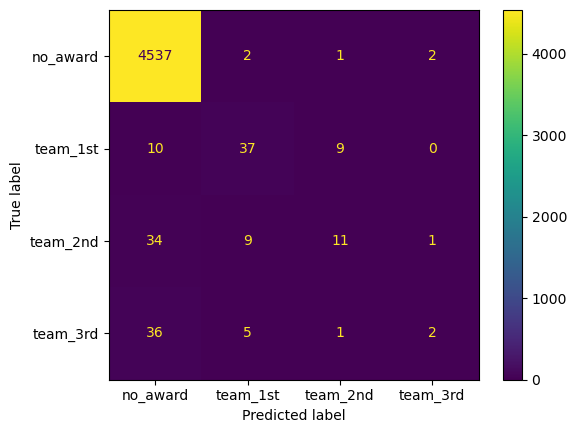

In [11]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sc, y_train)
# Predict on the test data
pred = rf.predict(X_test_sc)

evaluate_model(rf, pred, X_train_sc, y_train, X_test_sc, y_test)

It looks like our class imbalance is heavily skewing our model. We do a good job of predicting no award but not such a great job of predicting the other classes. Our model is also heavily struggling with false negatives and false positives for most of the all_nba teams.

# Changing Random Forest Class Weight

Training Accuracy: 1.0
Testing Accuracy: 0.975729188843943
F1 Score:
 no_award: 0.9902
 team_1st: 0.6667
 team_2nd: 0.1892
 team_3rd: 0.0435
Recall Score:
 no_award:  0.9998
 team_1st:  0.6071
 team_2nd:  0.1273
 team_3rd:  0.0227
Precision Score:
 no_award: 0.9808
 team_1st: 0.7391
 team_2nd: 0.3684
 team_3rd: 0.5000


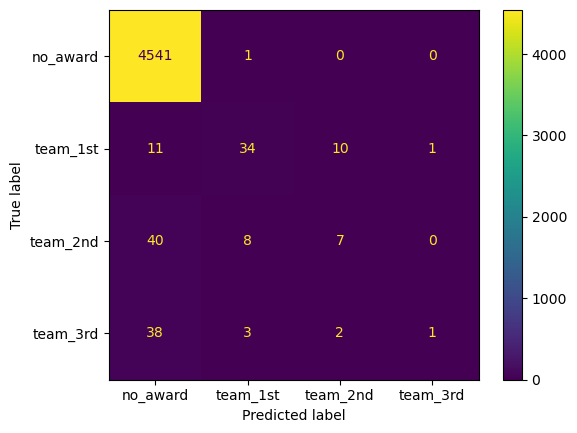

In [12]:
rf = RandomForestClassifier(n_estimators=100, class_weight= 'balanced', random_state=42)
rf.fit(X_train_sc, y_train)

# Predict on the test data
pred = rf.predict(X_test_sc)

evaluate_model(rf, pred, X_train_sc, y_train, X_test_sc, y_test)

Didn't help much. Still misclassifying most classes as no_award.

# Over-Sampling

In [26]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('smo', SMOTE(random_state=42, sampling_strategy = {
    0: 18169,
    1: 9000, 
    2: 9000,   
    3: 9000 
})),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balance'))])

params = {
    'smo__k_neighbors': [3, 5, 10],
    'rf__n_estimators': randint(100, 501),
    'rf__max_depth': [None, 10, 20, 50],
    'rf__min_samples_split': randint(2, 11),
    'rf__min_samples_leaf': randint(1, 5),
    'rf__max_features': ['sqrt', 'log2'],
    'rf__class_weight': [None, 'balanced'],
    'rf__criterion': ['gini', 'entropy'],
    'rf__bootstrap': [True, False]
}
    
grid = RandomizedSearchCV(pipe,
                      param_distributions=params,
                    n_iter=100,
                    scoring = 'f1_weighted',
                    n_jobs=-1,
                   random_state=42)

grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                             ('smo',
                                              SMOTE(random_state=42,
                                                    sampling_strategy={0: 18169,
                                                                       1: 9000,
                                                                       2: 9000,
                                                                       3: 9000})),
                                             ('rf',
                                              RandomForestClassifier(class_weight='balance',
                                                                     random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__class_weight': [None, 'balanced'],
                                        'rf__criterion': ['gin...
                                        'rf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177b92a10>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177ce98d0>,
                                        'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177c48a10>,
                                        'smo__k_neighbors': [3, 5, 10]},
                   random_state=42, scoring='f1_weighted')

In [28]:
print(grid.best_params_)
grid.best_score_

{'rf__bootstrap': False, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 50, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 3, 'rf__n_estimators': 317, 'smo__k_neighbors': 5}


0.9718604887193845

Training Accuracy: 1.0
Testing Accuracy: 0.9738673870255196
F1 Score:
 no_award: 0.9914
 team_1st: 0.6306
 team_2nd: 0.4000
 team_3rd: 0.3182
Recall Score:
 no_award:  0.9899
 team_1st:  0.6250
 team_2nd:  0.4545
 team_3rd:  0.3182
Precision Score:
 no_award: 0.9929
 team_1st: 0.6364
 team_2nd: 0.3571
 team_3rd: 0.3182


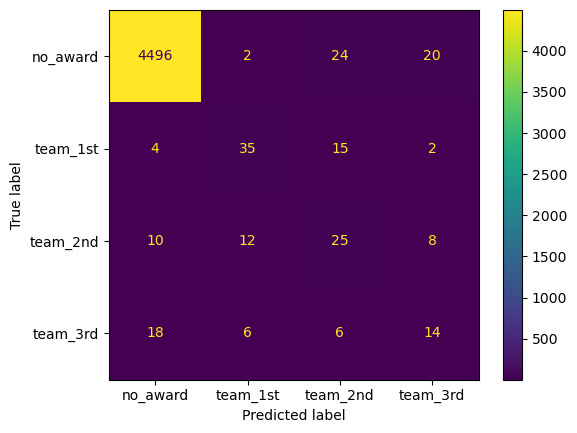

In [29]:
# Predict on the test data
pred = grid.predict(X_test)

evaluate_model(grid, pred, X_train, y_train, X_test, y_test)

In [17]:
pipe_2 = Pipeline([
    ('ss', StandardScaler()),
    ('smo', SMOTE(k_neighbors=5, random_state=42, sampling_strategy = {
    0: 18169,
    1: 9000, 
    2: 9000,   
    3: 9000 
})),
    ('rf', RandomForestClassifier(n_estimators=225, max_depth=None, min_samples_leaf=1, max_features='sqrt', random_state=42, class_weight='balanced', criterion='gini', bootstrap=False))])

params = {
    'rf__min_samples_split': [2, 5, 10]
}
    
grid_2 = GridSearchCV(pipe_2,
                      param_grid=params,
                    scoring = 'f1_weighted',
                    n_jobs=-1)

grid_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('smo',
                                        SMOTE(random_state=42,
                                              sampling_strategy={0: 18169,
                                                                 1: 9000,
                                                                 2: 9000,
                                                                 3: 9000})),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=False,
                                                               class_weight='balanced',
                                                               n_estimators=225,
                                                               random_state=42))]),
             n_jobs=-1, param_grid={'rf__min_samples_split': [2, 5, 10]},
             scoring='f1_weighted')

In [31]:
print(grid_2.best_params_)
grid_2.best_score_

{'rf__min_samples_split': 2}


0.9714243971231549

Training Accuracy: 1.0
Testing Accuracy: 0.9739374422052881
F1 Score:
 no_award: 0.9917
 team_1st: 0.6250
 team_2nd: 0.3894
 team_3rd: 0.3111
Recall Score:
 no_award:  0.9912
 team_1st:  0.6250
 team_2nd:  0.4000
 team_3rd:  0.3182
Precision Score:
 no_award: 0.9923
 team_1st: 0.6250
 team_2nd: 0.3793
 team_3rd: 0.3043


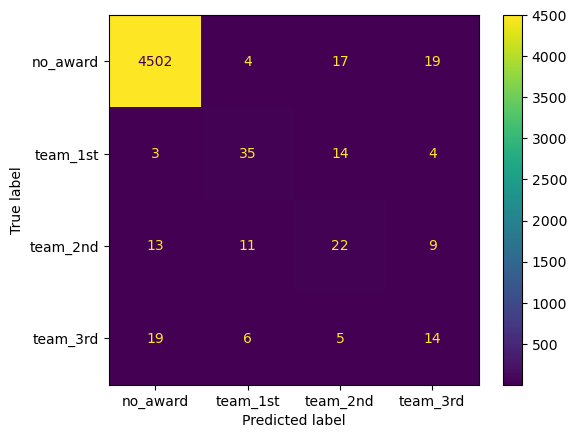

In [19]:
# Predict on the test data
pred_2 = grid_2.predict(X_test)

evaluate_model(grid_2, pred_2, X_train, y_train, X_test, y_test)

In [20]:
pipe_3 = Pipeline([
    ('ss', StandardScaler()),
    ('ada', ADASYN(random_state=42, sampling_strategy = {
    0: 18169,
    1: 9000, 
    2: 9000,   
    3: 9000 
})),
    ('rf', RandomForestClassifier(n_estimators=225, max_depth=None, min_samples_leaf=1, max_features='sqrt', random_state=42, class_weight='balanced', criterion='gini', bootstrap=False))])

params = {
    'ada__n_neighbors': randint(3, 11),
    'rf__min_samples_split': randint(2, 11)
}
    
grid_3 = RandomizedSearchCV(pipe_3,
                      param_distributions=params,
                    n_iter=50,
                    scoring = 'f1_weighted',
                    n_jobs=-1,
                    cv=3,
                   random_state=42)

grid_3.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ss', StandardScaler()),
                                             ('ada',
                                              ADASYN(random_state=42,
                                                     sampling_strategy={0: 18169,
                                                                        1: 9000,
                                                                        2: 9000,
                                                                        3: 9000})),
                                             ('rf',
                                              RandomForestClassifier(bootstrap=False,
                                                                     class_weight='balanced',
                                                                     n_estimators=225,
                                                                     random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'ada__n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177b46a50>,
                                        'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177a84690>},
                   random_state=42, scoring='f1_weighted')

In [25]:
print(grid_3.best_params_)
print(grid_3.best_score_)

{'ada__n_neighbors': 6, 'rf__min_samples_split': 9}
0.9715971613298545


Training Accuracy: 1.0
Testing Accuracy: 0.9752622849808517
F1 Score:
 no_award: 0.9927
 team_1st: 0.6789
 team_2nd: 0.3469
 team_3rd: 0.3429
Recall Score:
 no_award:  0.9963
 team_1st:  0.6607
 team_2nd:  0.3091
 team_3rd:  0.2727
Precision Score:
 no_award: 0.9891
 team_1st: 0.6981
 team_2nd: 0.3953
 team_3rd: 0.4615


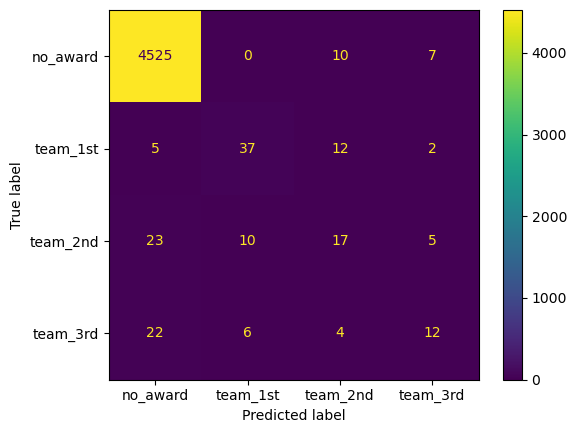

In [22]:
# Predict on the test data
pred_3 = grid_3.predict(X_test)

evaluate_model(grid_3, pred_3, X_train, y_train, X_test, y_test)

In [42]:
pipe_4 = Pipeline([
    ('ss', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=5, sampling_strategy = {
    0: 18169,
    1: 9000, 
    2: 9000,   
    3: 9000 
})),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))])

params = {
    'xgb__n_estimators': randint(100, 200),
    'xgb__max_depth': randint(3, 5),
    'xgb__learning_rate': uniform(0.01, 0.1),
    'xgb__subsample': uniform(0.5, 0.4),
    'xgb__colsample_bytree': uniform(0.8, 0.2),
    'xgb__gamma': uniform(0, 0.1),
    'xgb__min_child_weight': randint(1, 3),
    'xgb__reg_alpha': uniform(0, 0.01),
    'xgb__reg_lambda': uniform(0.1, 1)
}
    
grid_4 = RandomizedSearchCV(pipe_4,
                      param_distributions=params,
                    n_iter=50,
                    scoring = 'f1_weighted',
                    n_jobs=-1,
                    cv=3,
                    verbose=2,
                   random_state=42)

grid_4.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ss', StandardScaler()),
                                             ('smote',
                                              SMOTE(random_state=42,
                                                    sampling_strategy={0: 18169,
                                                                       1: 9000,
                                                                       2: 9000,
                                                                       3: 9000})),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=Fals...
                                        'xgb__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x177cfc7d0>,
                                        'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16abb9150>,
                                        'xgb__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x177bc4290>,
                                        'xgb__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x177c0ba50>},
                   random_state=42, scoring='f1_weighted', verbose=2)

Training Accuracy: 0.9932699969114743
Testing Accuracy: 0.9711936386776288
F1 Score:
 no_award: 0.9894
 team_1st: 0.6549
 team_2nd: 0.4098
 team_3rd: 0.1983
Recall Score:
 no_award:  0.9844
 team_1st:  0.6607
 team_2nd:  0.4545
 team_3rd:  0.2727
Precision Score:
 no_award: 0.9944
 team_1st: 0.6491
 team_2nd: 0.3731
 team_3rd: 0.1558


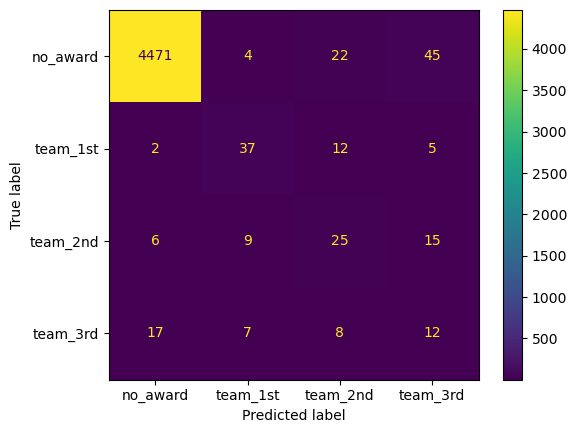

In [44]:
# Predict on the test data
pred_4 = grid_4.predict(X_test)

evaluate_model(grid_4, pred_4, X_train, y_train, X_test, y_test)

In [ ]:
pipe_5 = Pipeline([
    ('ss', StandardScaler()),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=225, max_depth=None, min_samples_leaf=1, max_features='sqrt', random_state=42, class_weight='balanced', criterion='gini', bootstrap=False))])

pipe_5.fit(X_train, y_train)

Training Accuracy: 0.981335604286424
Testing Accuracy: 0.9674260166063445
F1 Score:
 no_award: 0.9891
 team_1st: 0.6441
 team_2nd: 0.4267
 team_3rd: 0.3333
Recall Score:
 no_award:  0.9806
 team_1st:  0.6786
 team_2nd:  0.5818
 team_3rd:  0.4545
Precision Score:
 no_award: 0.9978
 team_1st: 0.6129
 team_2nd: 0.3368
 team_3rd: 0.2632


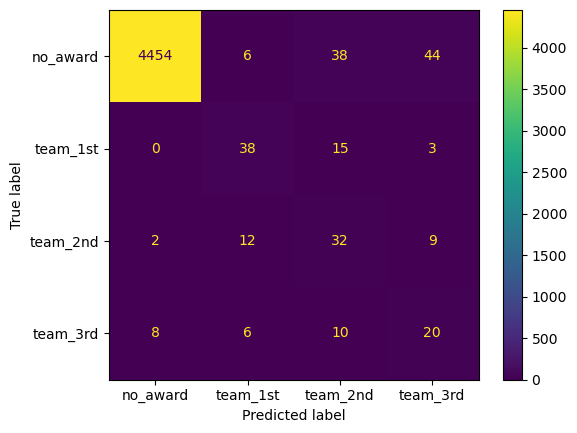

In [51]:
# Predict on the test data
pred_5 = pipe_5.predict(X_test)

evaluate_model(pipe_5, pred_5, X_train, y_train, X_test, y_test)